# Exploratory Data Analysis

The data are analyzed for potential features, redundancy, and dispersion.

## Extraction and Merging

This notebook extracts the data and performs analysis to test for feature availability. The data are first converted into a dictionary structure so that all flat file components can be referenced separately. Then, the component frames are respectively merged into two flat files on the common key that unites the tables within each component group.

In [1]:
import os
import glob
from typing import Dict, Union, List, Tuple
import logging
from functools import reduce
from copy import deepcopy
import pandas as pd
import numpy as np
import re, string
from pandas.core.tools.datetimes import _guess_datetime_format_for_array

# set logger level
logging.basicConfig(level=logging.INFO)

def data_into_dict(
        filepath: Union[str, List], 
) -> Dict[str, pd.DataFrame]:   
    """Read data from paths into dictionary values
    This is an example of Google style.

    Args:
        filepath (Union[str, List]) : string literal of list of strings pointing to files for io
    Returns:
        file_d: dictionary of files as dataframes, with key as filename abbreviation
    """
    logging.info(f"Filepaths: {filepath}")
    # create file dictionary
    file_d = dict()
    for f in filepath:
        # get abbreviation for key
        fname_abbr =  os.path.split(f)[1].split(".")[0]
        logging.info(f"Reading {f} into key {fname_abbr}")
        # read dataframe into value
        file_d[fname_abbr] = pd.read_csv(f)
    return file_d


# read in data from dir
data_path = "../data/data/"
# group filenames by prefix
a_files = data_into_dict(glob.glob(os.path.join(data_path, "a__*")))
b_files = data_into_dict(glob.glob(os.path.join(data_path, "b__*")))

# consolidate dataframe groups into merged structure 
def merge_all_frames(
    frames: Dict, 
    on: str, 
    how: str, 
    rename_exclusions: List=[]
) -> pd.DataFrame:
    """Merge all frames in list into single dataframe 

    Args:
        frames (Dict) : dict of dfs with frame values to merge into single frame
        on (str) : column to merge on 
        how (str) : merge type
        rename (List) : list of columns to not rename
    Returns:
        frame_merged (pd.DataFrame): merged dataframe
    """
    frames = deepcopy(frames)
    # append df key names to columns to resolve conflicts in col names
    for frame in frames.items(): 
        frames[frame[0]] = frame[1].rename({col:f"{col}_{frame[0]}" \
            for col in frame[1] if (col!=on) and (col not in rename_exclusions)}, axis=1)

    # merge frames and set key value as conflicting column suffixes
    logging.info(f"Merging values of {frames.keys()}")
    frame_merged = reduce(
                lambda  left,right: pd.merge(left,right,on=[on],how=how), frames.values()
            )
        
    return frame_merged

a_frame = merge_all_frames(a_files, on="geo_id", how='outer', rename_exclusions=['vendor_id'])
b_frame = merge_all_frames(b_files, on="b_entity_id", how='outer')

a_frame = a_frame.set_index("vendor_id").reset_index()
b_frame = b_frame.set_index("b_entity_id").reset_index()

INFO:root:Filepaths: ['../data/data/a__geo.csv', '../data/data/a__company.csv']
INFO:root:Reading ../data/data/a__geo.csv into key a__geo
INFO:root:Reading ../data/data/a__company.csv into key a__company
INFO:root:Filepaths: ['../data/data/b__company.csv', '../data/data/b__hierarchy.csv', '../data/data/b__address.csv']
INFO:root:Reading ../data/data/b__company.csv into key b__company
INFO:root:Reading ../data/data/b__hierarchy.csv into key b__hierarchy
INFO:root:Reading ../data/data/b__address.csv into key b__address
/var/folders/vn/k48mm0r10wn2dfq08pnrlbtc0000gn/T/ipykernel_52162/1867531294.py:34: DtypeWarning: Columns (11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  file_d[fname_abbr] = pd.read_csv(f)
INFO:root:Merging values of dict_keys(['a__geo', 'a__company'])
INFO:root:Merging values of dict_keys(['b__company', 'b__hierarchy', 'b__address'])


In [3]:
# import DisparateDataset class
import sys
if "../src/" not in sys.path:
    sys.path.append("../src/")
from main import DisparateDataset as DispD

# conduct type compression from dataloader class for cleaning
a_comp = DispD.run_type_compression(frame=a_frame, column_exclusions=['vendor_id'])
b_comp = DispD.run_type_compression(frame=b_frame, column_exclusions=['b_entity_id'])
a_comp.to_csv("../data/artifacts/a_comp.csv", index=False)
b_comp.to_csv("../data/artifacts/b_comp.csv", index=False)

INFO:root:Pointing to column in position 0
INFO:root:Column vendor_id excluded.
INFO:root:Pointing to column in position 1
INFO:root:Working compression on column geo_id
INFO:root:Numeric proportion for geo_id: 1.0
INFO:root:Converted column geo_id into Int64 type.
INFO:root:Pointing to column in position 2
INFO:root:Working compression on column zipcode_a__geo
INFO:root:Numeric proportion for zipcode_a__geo: 0.9727074016884913
INFO:root:Converted column zipcode_a__geo into Int64 type.
INFO:root:Pointing to column in position 3
INFO:root:Working compression on column is_primary_a__geo
INFO:root:Numeric proportion for is_primary_a__geo: 0
INFO:root:Converted column is_primary_a__geo into string type.
INFO:root:Pointing to column in position 4
INFO:root:Working compression on column latitude_a__geo
INFO:root:Numeric proportion for latitude_a__geo: 0.9878210806023029
INFO:root:Converted column latitude_a__geo into float type.
INFO:root:Pointing to column in position 5
INFO:root:Working co

In [4]:
logging.info(f"a_frame shape: {a_frame.shape}")
logging.info(f"a_comp shape: {a_comp.shape}")
logging.info(f"b_frame shape: {b_frame.shape}")
logging.info(f"b_comp shape: {b_comp.shape}")

INFO:root:a_frame shape: (76344, 45)
INFO:root:a_comp shape: (76344, 45)
INFO:root:b_frame shape: (200239, 37)
INFO:root:b_comp shape: (200239, 37)


## Clustering and Analysis

The data are fit in an unsupervised manner. The datasets are tested for similarity by clustering around an arbitrary number of centroids. Finally, the elbow for each SSE curve is found using a knee locator. The elbows are found to be at approximately ~0.5 SSE and is fit at 3 centroids for both distributions.

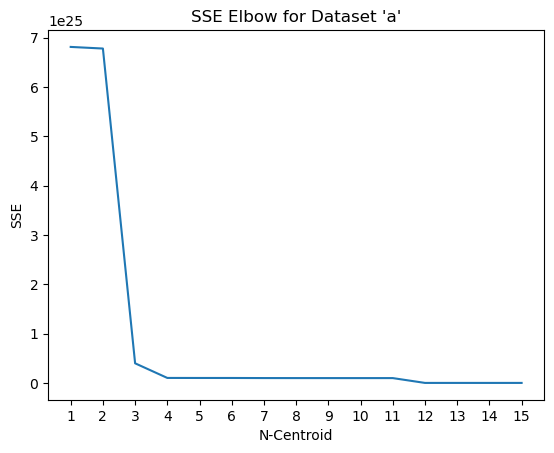

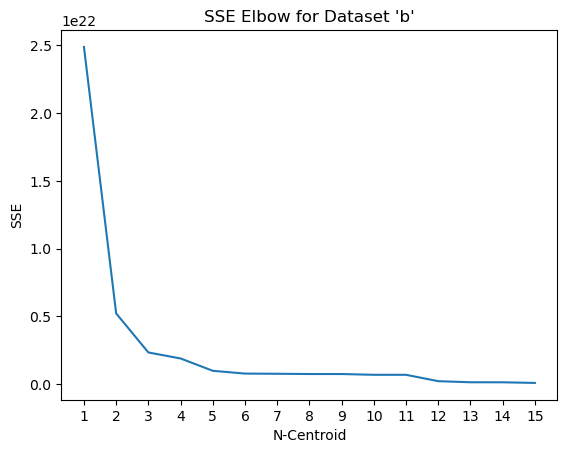

INFO:root:Elbow for dataset 'a': 3
INFO:root:Elbow for dataset 'b': 3


In [28]:
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def centroid_analysis(
    frame: pd.DataFrame,
    index: str, 
    kmeans_parameters: Dict[str, Union[int, str]], 
    kmeans_iter: int, 
    visualize: bool=False, 
    **kwargs
) -> int:
    """Find optimal number of centroids through recommended evaluation metric

    Function that find the optimal number of centroids in a dataset. Used to evaluate unlabeled datasets for 
    similarity metrics. 

    Args:   
        frame (pd.DataFrame) : frame used to find centroids
        index (str) : primary index of frame
        kmeans_parameters (Dict[str, Union[int, str]]) : kmeans values used as parameters
        kmeans_iter (int) : number of iterations to run on kmeans cluster
        eval_method (int) : method of evaluation 
        visualize (bool) : visualization preference for elbow analysis
    Returns: 
        n_centroids (int) : number of centroids that are considered optimal
    """

    comp_num = frame[[col for col, datatype in frame.dtypes.to_dict().items() if (datatype != np.dtype('O'))or (col==index)]]
    # check primary index for all unique values
    if comp_num.index.value_counts().max()==1: 
        # fill NA with null class flag 0
        comp_dropna = comp_num.set_index(index).fillna(0)
        col_map = comp_dropna.columns.to_numpy()
        comp_vals = comp_dropna.values.astype('float')
    # if non-unique primary index, consolidate based upon append-only insert on schema
    else:
        # get last index for each group
        max_index_per_entity = comp_num.reset_index().groupby(index)['index'].max()
        # fill NA with null class flag 0
        comp_dropna = comp_num.iloc[list(max_index_per_entity.values)].set_index(index).fillna(0)
        col_map = comp_dropna.columns.to_numpy()
        comp_vals = comp_dropna.values.astype('float')
    # start inertia compilation
    inertia_values = list()
    for i in range(1,kmeans_iter):
        km = KMeans(n_clusters=i, **kmeans_parameters)
        # fit data to numpy data
        km.fit(comp_vals)
        inertia_values.append(km.inertia_)
    if visualize:
        plt.xticks(range(1, kmeans_iter))
        plt.plot(range(1, kmeans_iter), inertia_values)
        plt.xlabel("N-Centroid")
        plt.ylabel("SSE")
        if ("plot_title" in kwargs.keys()):
            plt.title(kwargs.get("plot_title"))
        plt.show()
    # return elbow from method
    knee = KneeLocator(
        range(1, kmeans_iter), 
        inertia_values, 
        curve="convex",
        direction="decreasing"
    )
    elbow = knee.elbow
    return elbow, comp_vals, col_map

a_elbow, a_comp_vals, a_col_map = centroid_analysis(
    frame=a_comp, 
    index='vendor_id', 
    kmeans_parameters={
        "init": "random",
        "n_init": 10,
        "max_iter": 500,
        "random_state": 0,
    }, 
    kmeans_iter=16, 
    visualize=True, 
    plot_title="SSE Elbow for Dataset 'a'"
)
b_elbow, b_comp_vals, b_col_map = centroid_analysis(
    frame=b_comp, 
    index='b_entity_id', 
    kmeans_parameters={
        "init": "random",
        "n_init": 10,
        "max_iter": 500,
        "random_state": 0,
    }, 
    kmeans_iter=16,
    visualize=True,
    plot_title="SSE Elbow for Dataset 'b'"
)

logging.info(f"Elbow for dataset 'a': {a_elbow}")
logging.info(f"Elbow for dataset 'b': {b_elbow}")

## Normalized Correlation Analysis

Normalized information for all columns is analyzed within each dataset.

In [29]:
import plotly.express as px

# compute normalization for arrays on all columns
def normalize_columns(
    comp_vals: np.array,
    col_map: Dict, 
    **kwargs
) -> Tuple[np.array, np.array]:
    """Normalize viable columns on array

    Broadcast a normalization of features to numpy array containing data. 
    This normalized data can then be used for correlation analysis.
    Args: 
        comp_vals (np.array) : Comparative values from derived dataset
        col_map (Dict) : dictionary of column value names
    Returns: 

    """
    # drop any columns if all zero
    where_any = np.where(np.any(comp_vals, axis=0))[0]
    # grab columns where sum is non zero
    comp_vals = comp_vals[:, where_any]
    col_map_slice = deepcopy(col_map)
    # remove zero sum columns from 
    col_map = col_map[where_any]
    # get max for each column 
    col_max = comp_vals.max(axis=0)
    col_min = comp_vals.min(axis=0)
    # find where max and min are equal
    viable_dist = np.where(np.not_equal(col_max, col_min))[0]
    comp_vals = comp_vals[:, viable_dist]
    col_max = col_max[viable_dist]
    col_min = col_min[viable_dist]
    col_map = col_map[viable_dist]
    # broadcast normalization
    comp_dist_min = (comp_vals-col_min)
    # convert from object type to float on final operation
    comp_norm = comp_dist_min/(col_max-col_min)
    logging.info(f"shape of normalized array {comp_norm.shape}")
    return comp_norm, col_map


a_norm, a_norm_cols = normalize_columns(a_comp_vals, a_col_map)
b_norm, b_norm_cols = normalize_columns(b_comp_vals, b_col_map)
# get pearson correlation matrix for each of the numeric values
a_corr_coef = np.corrcoef(a_norm, rowvar=False)
b_corr_coef = np.corrcoef(b_norm, rowvar=False)

a_corr_df = pd.DataFrame(data=a_corr_coef, index=a_norm_cols, columns=a_norm_cols)
b_corr_df = pd.DataFrame(data=b_corr_coef, index=b_norm_cols, columns=b_norm_cols)


fig = px.imshow(a_corr_df, title="Correlation Matrix for Dataset 'a'")
fig.show()
fig = px.imshow(b_corr_df, title="Correlation Matrix for Dataset 'b'")
fig.show()


INFO:root:shape of normalized array (76344, 22)
INFO:root:shape of normalized array (200239, 15)


## K-S Test for Distributional Similarity Between Columns

Use the kolomogorov-smirnov 2-sample test to retrieve a D-statistic comparing features' hypothetical class distributions in the 'a' dataset to the 'b' dataset. This will allow us to parse out features that can be compared and used to join the two datasets.

In [30]:
def get_balance_distribution(
    features: np.array
) -> List: 
    """Get the balance distribution for each feature in numpy array
    
    Args:
        features (np.array) : feature set
    Returns: 
        balance_distributions (List) : list of balance distributions for each column in array
    """
    balance_distributions = []
    for i in range(features.shape[1]):
        feature = features[:, i]
        # get unique values for feature
        unique, counts = np.unique(feature, return_counts=True)
        # get count for each unique value in array
        counts = np.asarray((unique, counts)).T[:, 1]
        # get count distribution
        count_distribution = counts/sum(counts)
        balance_distributions.append(count_distribution)
    return balance_distributions
    

In [31]:
a_bd = get_balance_distribution(a_comp_vals)
b_bd = get_balance_distribution(b_comp_vals)

In [32]:
from scipy.stats import ks_2samp

d_stat = np.zeros(shape=(len(a_bd), len(b_bd)))
for i, a_dist in enumerate(a_bd):
    for j, b_dist in enumerate(b_bd):
        d_stat[i][j] = ks_2samp(a_dist,b_dist).statistic

In [33]:
import plotly.express as px

stat_df = pd.DataFrame(data = -d_stat, index=a_col_map, columns=b_col_map)
stat_df.to_csv("../data/artifacts/ks_stat_df.csv", index=False)
fig = px.imshow(stat_df, title="Kolmogorov-Smirnov 2-sample Distributional Similarity Heatmap")
fig.show()